In [55]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [4]:
data_seed, params_seed = 42, 120

(42, 120)

In [5]:
import ReactiveMP.messageout

In [7]:
include("../helpers/data.jl")

generate_data

In [8]:
# order = 1
Y = zeros(3); Y[1] = 1.0;
U = zeros(3); U[2] = 1.0;
H = zeros(3); H[3] = 1.0;

In [9]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    
    dimension = length(h_prior[1])

    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(0.0, 1e12))}  
    w       = randomvar()
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    Ys = [Y*y_prev[i] for i in 1:n]
    Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Univariate, 1, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ NormalMeanPrecision(0.0, 1e12)
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dimension*3))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [10]:
function nonlinear_max_inference(observations, observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(0.0, 0.1), w_prior=(0.1, 1.0), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior, w_prior,
                                                                       observations_prev, controls,
                                                                       options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [11]:
# specify flow model
dimension = 3
model_flow = FlowModel(dimension,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [12]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>1, :order_u=>1, :order_e=>1),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [13]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[1:end];

In [14]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

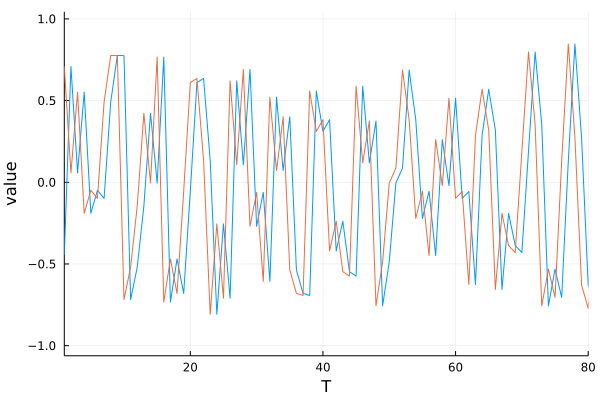

In [15]:
from, to = 1, 80
plot(y_obs, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value", legend=false)

In [34]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = randn(flow_param_len)

18-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
 -0.3197351351892221
 -1.2564553841314527
  0.9521825170300846
 -1.1950939635125657
 -0.8705419973267794

In [35]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, w_prior=(1e2, 1.0), vmp_its=5);


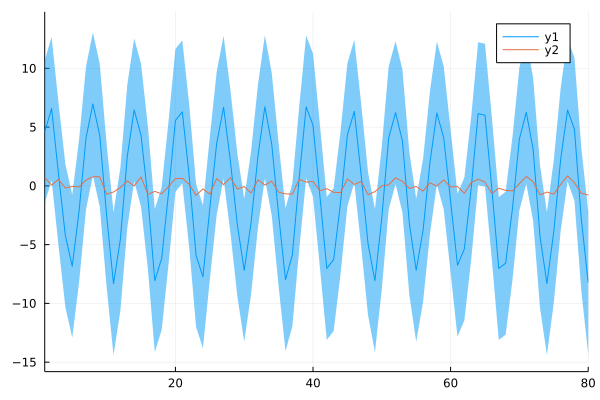

In [36]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

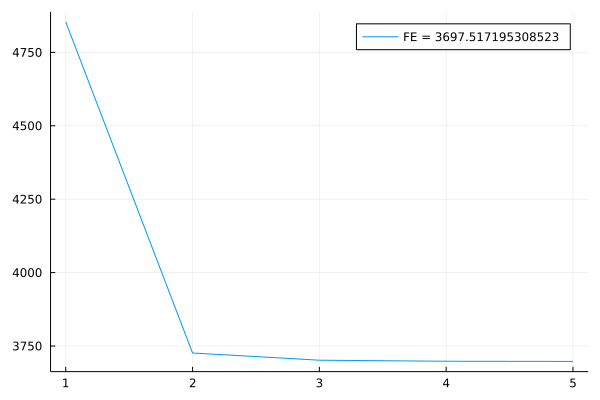

In [37]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [38]:
# Optimization function
function FE(params)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(0.0, 0.1), w_prior=(1e4, 1.0), 
                                                 vmp_its=5)
    return fe[end]
end;

In [39]:
FE(model_params)

99877.96753544113

In [26]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [-1.94966, 1.56914, -0.146374, -0.203105, 2.60121, 6.77963, -…

In [83]:
import ReactiveMP.fastcholesky
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [40]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-8, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)


Iter     Function value   Gradient norm 
     0     9.987796e+04     3.796195e+03
 * time: 0.018435955047607422
    10     7.343412e+04     5.021287e+03
 * time: 110.3956139087677
    20     6.880184e+04     5.175787e+03
 * time: 161.49695897102356
    30     6.704236e+04     4.983961e+03
 * time: 213.48930406570435
    40     6.546350e+04     1.142071e+04
 * time: 271.0480389595032
    50     6.417023e+04     9.869250e+03
 * time: 328.44867396354675
    60     6.334294e+04     8.712817e+03
 * time: 386.98120307922363
    70     6.280691e+04     7.253859e+03
 * time: 445.6963438987732
    80     6.240838e+04     6.494843e+03
 * time: 503.03405499458313
    90     6.208993e+04     6.004470e+03
 * time: 560.633358001709
   100     6.182181e+04     5.773297e+03
 * time: 617.6690299510956
   110     6.159393e+04     5.492106e+03
 * time: 675.0063800811768
   120     6.139783e+04     5.151120e+03
 * time: 728.3139550685883
   130     6.121024e+04     5.225598e+03
 * time: 785.7893300056458


 * Status: success

 * Candidate solution
    Final objective value:     5.903730e+04

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.91e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   1721  (vs limit Inf)
    Iterations:    264
    f(x) calls:    744
    ∇f(x) calls:   744


In [41]:
inf_params = Optim.minimizer(res)

18-element Vector{Float64}:
 -1.9042506373805228
  1.687865625099113
 -0.25574714512212504
 -2.3508047000188226
  0.8518130769048886
  0.9338920518239546
  3.1535801457985007
 -0.8234627162950291
  0.9908455575640116
  0.9138367565540064
 -1.0218354967848284
 -0.16594204547922092
  2.053214203929315
 -0.7298247131472438
 -0.18401485404583184
  3.1902841283456764
 -2.0542861086780198
 -0.9648203393350452

In [42]:
using JLD
JLD.save("../dump/flow_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [43]:
FE(inf_params)

59045.75501406594

In [44]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=100);


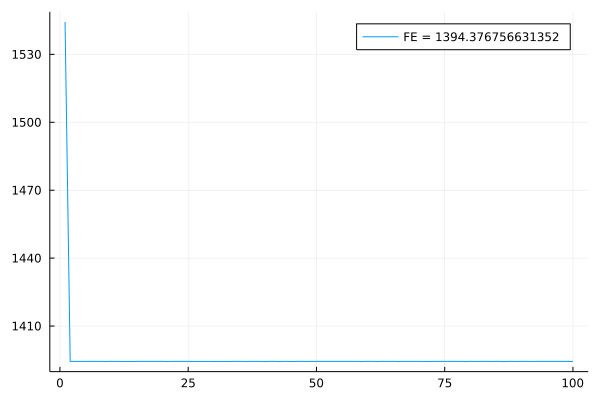

In [45]:
plot(fe_[1:end], label="FE = $(fe_[end])")

In [46]:
from, to = 100, 150

(100, 150)

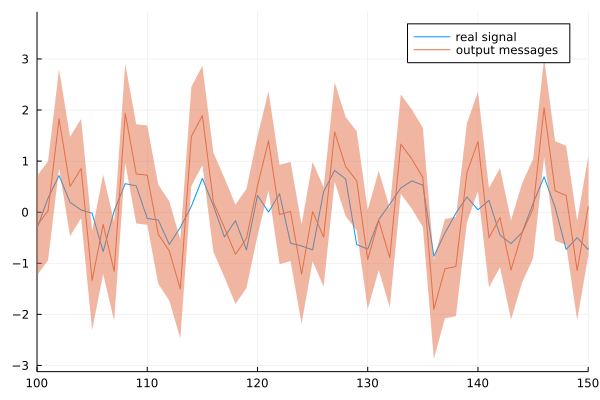

In [47]:
my, vy = mean.(y_out_), cov.(y_out_)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

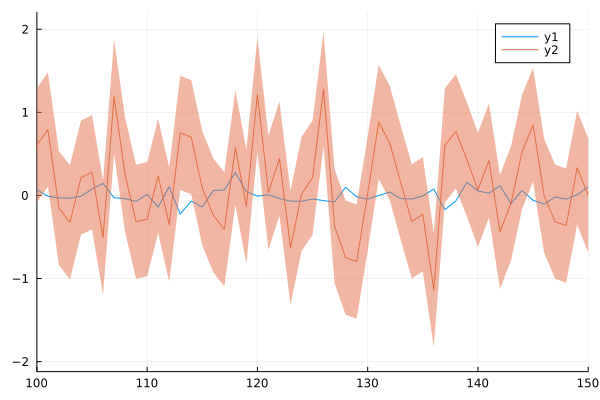

In [48]:
mh, vh = mean.(h_), cov.(h_)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [49]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_model(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dimension = length(h_prior[1])

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])
    
    h ~ NormalMeanPrecision(h_0, w) where {q = q(h_0, h)q(w)}
    
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dimension*3))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_model (generic function with 1 method)

In [50]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_model(model_flow, params, w, h_prior,
                                                                                          observation_prev, control,
                                                                                          options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 1 method)

In [51]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, vmp_its=10);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [52]:
mx, vx = mean.(predictions), cov.(predictions)

([0.965969977722026, -3.628361674878937, -2.8857895187606246, -2.4196187092258135, 1.968307363550336, 3.542782420200195, -1.2827955967264215, -0.6800473926186928, -3.5192093968654277, 2.184517467945892  …  -1.72446999851312, 0.15694206153268858, -1.013920835950321, 2.9538381541485967, 1.6817615865253026, -0.6786251191733618, -0.8513730838931097, -0.9318637398280063, -3.0265040910352883, 3.383119804876237], [2.361510352638036, 2.926199984843845, 3.8651179110006693, 2.8330981830244135, 3.1345276540102, 3.511621789431972, 3.277608180679442, 3.1427592262441792, 3.3534260616067773, 3.5208478205466665  …  3.017072640314821, 2.7967894071408437, 2.958158149469922, 3.6002966946579895, 3.1260928817966653, 3.0866708023259544, 2.7602451708039677, 3.4055882096082564, 3.123667085274555, 3.0840330646742333])

In [53]:
test_from, test_to = 1, 40

(1, 40)

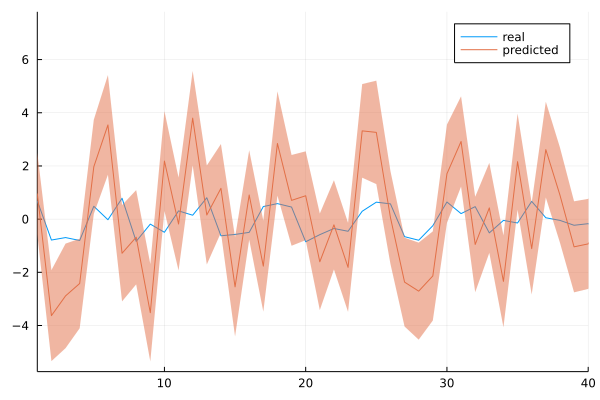

In [54]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")